In [2]:


# Encoding variables
df = pd.get_dummies(df, prefix=['customer_state: '], columns=[
                    'customer_state'], drop_first=False)
df = pd.get_dummies(df, prefix=['payment_type: '], columns=[
                    'payment_type'], drop_first=False)
df = pd.get_dummies(df, prefix=['seller_state: '], columns=[
                    'seller_state'], drop_first=False)
df = pd.get_dummies(df, prefix=['product_category_name: '], columns=[
                    'product_category_name_english'], drop_first=False)

# Calculating the RFM

# Recency = time since a customer's last purchase
# Calculating each purchasing time stamp minus the most recent purchase timestamp (max)
df['recency'] = max(df['order_purchase_timestamp']) - \
    df['order_purchase_timestamp']
# Getting the minimum recency value for each customer (customer with multiple purchases ended up with multiple recencies, therefore calculating the most recent purchase)
df['recency'] = df.groupby(['customer_unique_id'], as_index=False)[
    'recency'].transform('min')
# Keeping only the days in the column, leaving out the time
df['recency'] = df['recency'].dt.days

# Frequency = how many times has a customer made a purchase
# Counting purchases per customer unique id and adding values to a new column in the dataset
df['frequency'] = df.groupby(['customer_unique_id'], as_index=False)[
    'order_id'].transform('count')

# Monetary = total amount a customer has spend purchasing products
# Calculating it by summing all the payment values a customer has spent
df['monetary'] = df.groupby(['customer_unique_id'], as_index=False)[
    'payment_value'].transform('sum')

# Creating an empty column to calculate recency score
df['recency_score'] = ''

# For function that inputs the score in the empty column based on the conditions set
# The numbers were chosen based of the recency mean, std, max and min + our reasoning considered aspects like "how many months could we consider the customer inactive?"
print('recency mean: ', df['recency'].mean())
print('recency std: ', df['recency'].std())
print('recency max: ', df['recency'].max())
print('recency min: ', df['recency'].min())

for i in df.index:
    if df['recency'][i] <= 30:
        df['recency_score'][i] = 5
    elif (df['recency'][i] > 30) and (df['recency'][i] <= 60):
        df['recency_score'][i] = 4
    elif (df['recency'][i] > 60) and (df['recency'][i] <= 120):
        df['recency_score'][i] = 3
    elif (df['recency'][i] > 120) and (df['recency'][i] <= 180):
        df['recency_score'][i] = 2
    elif (df['recency'][i] > 180):
        df['recency_score'][i] = 1

# Creating an empty column to calculate frequency score
df['frequency_score'] = ''

# For function that inputs the score in the empty column based on the conditions set
# The numbers were chosen based of the recency mean, std, max and min + our reasoning considered aspects like "most customers purchased only one time, and max purchases were 13, how can we score from 0 to above"
print('frequency mean: ', df['frequency'].mean())
print('frequency std: ', df['frequency'].std())
print('frequency max: ', df['frequency'].max())
print('frequency min: ', df['frequency'].min())

for i in df.index:
    if df['frequency'][i] >= 10:
        df['frequency_score'][i] = 5
    elif (df['frequency'][i] >= 6) and (df['frequency'][i] < 10):
        df['frequency_score'][i] = 4
    elif (df['frequency'][i] >= 4) and (df['frequency'][i] < 6):
        df['frequency_score'][i] = 3
    elif (df['frequency'][i] >= 2) and (df['frequency'][i] < 4):
        df['frequency_score'][i] = 2
    elif (df['frequency'][i] == 1):
        df['frequency_score'][i] = 1

# Creating an empty column to calculate monetary score
df['monetary_score'] = ''

# For function that inputs the score in the empty column based on the conditions set
# The numbers were chosen based of the recency mean, std, max and min + our reasoning considered aspects like "the mean of the payment was 395.1, and the std is 1090.5, how can we score the customers based on spending"
print('monetary mean: ', df['monetary'].mean())
print('monetary std: ', df['monetary'].std())
print('monetary max: ', df['monetary'].max())
print('monetary min: ', df['monetary'].min())

for i in df.index:
    if df['monetary'][i] > 500:
        df['monetary_score'][i] = 5
    elif (df['monetary'][i] > 250) and (df['monetary'][i] <= 500):
        df['monetary_score'][i] = 4
    elif (df['monetary'][i] > 150) and (df['monetary'][i] <= 250):
        df['monetary_score'][i] = 3
    elif (df['monetary'][i] > 100) and (df['monetary'][i] <= 150):
        df['monetary_score'][i] = 2
    elif (df['monetary'][i] <= 100):
        df['monetary_score'][i] = 1

# Uniting the scores in the same columns to find segments such as 555 (5 score for all rfm)
df['rfm_segment'] = df['recency_score'].astype(
    str) + df['frequency_score'].astype(str) + df['monetary_score'].astype(str)

# Calculating total score (sum of all val)

# Turning all numbers from last created columns to numeric variables to use in future analysis
df['rfm_segment'] = pd.to_numeric(df['rfm_segment'])
df['recency_score'] = pd.to_numeric(df['recency_score'])
df['frequency_score'] = pd.to_numeric(df['frequency_score'])
df['monetary_score'] = pd.to_numeric(df['monetary_score'])

# Creating a dataframe with the rfm variables that are going to be used in the clustering algorithms
rfm = df[['recency', 'frequency', 'monetary']]

# Plotting a few exploratory graphs for rfm

# Customers who order 1 time and 2 times are predominant. There fewer customers are the ones that have ordered more than 5 times.
plt.figure(figsize=(8, 5))
sns.distplot(df['frequency'], bins=8, kde=False, rug=True)
plt.figure()

# The ammount customers spend is frequently less than 300$.
plt.figure(figsize=(8, 5))
sns.distplot(df['monetary'], kde=False, rug=True)
plt.xlim(0, 2000)

# Customers who had come within the last 2 months are the majority and there are some customers that have not ordered for more than a year.
plt.figure(figsize=(8, 5))
sns.distplot(df['recency'], bins=8, kde=False, rug=True)

# Standardizing the features
scaler = StandardScaler()
rfm_std = scaler.fit_transform(rfm)

# Segmenting the custumer in Gold, Silver and Bronze according to their scores in frequency, recency and monetary value
# and keeping in mind that we assinged to recency a lower weight since in our opinion is a less impotant factor to determine future customer behavior.
df['customer_category'] = ((df['monetary_score']*2) +
                           (df['frequency_score']*2) + (df['recency_score']*1)) / 5

for i in df.index:

    if (df['customer_category'][i] >= 4) and (df['customer_category'][i] <= 5):
        df['customer_category'][i] = 'Gold'
    elif (df['customer_category'][i] > 2) and (df['customer_category'][i] < 4):
        df['customer_category'][i] = 'Silver'
    elif (df['customer_category'][i] >= 1) and (df['customer_category'][i] <= 2):
        df['customer_category'][i] = 'Bronze'

def generate_legend_labels(chart_data, chart_labels):
    total_values = sum(chart_data.values)

    for key, value in chart_data.items():
        value_percentage = value / total_values * 100
        rounded_value_percentage = round(value_percentage, 1)
        chart_labels.append(key + ' - ' + str(rounded_value_percentage) + '%')

# Plotting the percentege of bronze, silver and gold customers
colors = ['#8B7355', '#C0C0C0', '#EEC900']
customer_category = df.groupby(['customer_category']).count().sort_values(
    by=['customer_id'], ascending=False)['customer_id']

customer_category_labels = []
customer_category_sizes = customer_category.values
generate_legend_labels(customer_category, customer_category_labels)

# Generates the pie chart
customer_category_chart, customer_category_ax = plt.subplots()
customer_category_ax.pie(customer_category_sizes,
                         shadow=True, startangle=90, colors=colors)
customer_category_ax.axis('equal')

plt.legend(labels=customer_category_labels, loc='upper left',
           bbox_to_anchor=(-0.25, 1.), fontsize=9)
customer_category_ax.set_title(
    'Percentage of each customer segment', fontweight='bold')
plt.show()

# Clustering algorithms

# K means clustering

# Importing libraries for K-means algorithm and performance measurments

# Using elbow method to find out optimal k value with WCSS score
# Creating empty list to insert values
WCSS = []

# Using a for function to fill the list with the WCSS scores
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(rfm_std)
    WCSS.append(kmeans.inertia_)

# Plotting the Elbow method graph
plt.figure()
plt.plot(range(1, 11), WCSS, marker='o', label='line with marker')
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Fitting K-Means to the dataset
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=42)
# Use fit_predict to cluster the dataset
km_clusters = kmeans.fit_predict(rfm_std)

rfm_std_cl = pd.DataFrame(rfm_std, columns=rfm.columns, index=rfm.index)
rfm_std_cl['cluster'] = km_clusters

# Visualising the clusters (3 clusters according to the Elbow method)
plt.scatter(rfm_std[km_clusters == 0, 0], rfm_std[km_clusters ==
            0, 1], s=30, c='orange', label='Cluster 1')
plt.scatter(rfm_std[km_clusters == 1, 0], rfm_std[km_clusters ==
            1, 1], s=30, c='brown', label='Cluster 2')
plt.scatter(rfm_std[km_clusters == 2, 0], rfm_std[km_clusters ==
            2, 1], s=30, c='gray', label='Cluster 3')
plt.scatter(kmeans.cluster_centers_[:, 0], kmeans.cluster_centers_[
            :, 1], s=150, c='black', label='Centroids')
plt.title('Clusters of customers')
plt.legend()
plt.show()

# Calculating cluster validation metrics (silhouette score, calinski harabasz score, davies bouldin score)
score_kemans_s = silhouette_score(rfm_std, kmeans.labels_, metric='euclidean')
score_kemans_c = calinski_harabasz_score(rfm_std, kmeans.labels_)
score_kemans_d = davies_bouldin_score(rfm_std, km_clusters)
print('Silhouette Score: %.3f' % score_kemans_s)
print('Calinski Harabasz Score: %.3f' % score_kemans_c)
print('Davies Bouldin Score: %.3f' % score_kemans_d)

# Hierarchical clustering

# Plotting the dendrogram to find the optimal number of clusters
plt.figure()
dendrogram = sch.dendrogram(sch.linkage(rfm_std, method='ward'))
plt.title('Dendrogram')
plt.xlabel('Customers')
plt.ylabel('Euclidean distances')
plt.xticks([])
plt.show()

# Fitting Hierarchical Clustering to the dataset
hc = AgglomerativeClustering(
    n_clusters=4, affinity='euclidean', linkage='ward')
hc_clusters = hc.fit_predict(rfm_std)

# Visualising the clusters (4 clusters according to the Dendogram)
plt.figure()
plt.scatter(rfm_std[hc_clusters == 0, 0], rfm_std[hc_clusters == 0, 1], s = 30, c = 'orange', label = 'Cluster 1')
plt.scatter(rfm_std[hc_clusters == 1, 0], rfm_std[hc_clusters == 1, 1], s = 30, c = 'brown', label = 'Cluster 2')
plt.scatter(rfm_std[hc_clusters == 2, 0], rfm_std[hc_clusters == 2, 1], s = 30, c = 'gray', label = 'Cluster 3')
plt.scatter(rfm_std[hc_clusters == 3, 0], rfm_std[hc_clusters == 3, 1], s = 30, c = 'yellow', label = 'Cluster 4')
plt.title('Clusters of customers')
plt.legend()
plt.show()

# Calculating cluster validation metrics
score_AGclustering_s = silhouette_score(
    rfm_std, hc.labels_, metric='euclidean')
score_AGclustering_c = calinski_harabasz_score(rfm_std, hc.labels_,)
score_AGclustering_d = davies_bouldin_score(rfm_std, hc_clusters)
print('Silhouette Score: %.3f' % score_AGclustering_s)
print('Calinski Harabasz Score: %.3f' % score_AGclustering_c)
print('Davies Bouldin Score: %.3f' % score_AGclustering_d)

# DBSCAN clustering

# Since the DBSCAN code runs only with dataframes, first, we transformed the standardized array to a DataFrame
rfm_std_df = pd.DataFrame(rfm_std, columns=rfm.columns)

# Tuning the hyperparameters

# Finding the 'n'
min_sample = 2*len(rfm_std_df.columns)
print(min_sample)  # equal to 6

# Finding the epsilon
# n = 7 because the first column will be of zeros
nbrs = NearestNeighbors(n_neighbors=7).fit(rfm_std_df)
# finding the k neighbors to each point
neigh_dist, neigh_ind = nbrs.kneighbors(rfm_std_df)
sort_neigh_dist = np.sort(neigh_dist, axis=0)  # sorting in ascending order

# Plotting the graph to visualize which is the optimal epsilon value
k_dist = sort_neigh_dist[:, 6]
plt.plot(k_dist)
# 0.4 chosen as it crosses the middle of the curve in the graph = optimal epsilon
plt.axhline(y=0.4, linewidth=1, linestyle='dashed', color='k')
plt.ylabel("k-NN distance")
plt.xlabel("Observations")
plt.show()

# Fitting the model
dbscan_model = DBSCAN(eps=0.4, min_samples=6).fit(rfm_std_df)
labels = dbscan_model.labels_
rfm_std_df["LABEL"] = labels
rfm_std_df.head(10)

# Plotting the graph to find the clusters
g = sns.PairGrid(rfm_std_df, hue='LABEL', palette="Paired")
g = g.map(sns.scatterplot)
print(g)

# Fitting model and predicting clusters
dbscan_clusters = dbscan_model.fit_predict(rfm_std_df)

# Calculating cluster validation metrics
score_dbsacn_s = silhouette_score(
    rfm_std_df, dbscan_clusters, metric='euclidean')
score_dbsacn_c = calinski_harabasz_score(rfm_std_df, dbscan_clusters)
score_dbsacn_d = davies_bouldin_score(rfm_std_df, dbscan_clusters)
print('Silhouette Score: %.3f' % score_dbsacn_s)
print('Calinski Harabasz Score: %.3f' % score_dbsacn_c)
print('Davies Bouldin Score: %.3f' % score_dbsacn_d)

# Considering the validation metrics, K-means was our best model

# Interpreting the clusters in K-means
print('Size of each cluster: ')
print(rfm_std_cl['cluster'].value_counts())

# Separating clusters in different dataframes
cluster0 = pd.DataFrame()
cluster1 = pd.DataFrame()
cluster2 = pd.DataFrame()

for i in rfm_std_cl.index:
    if rfm_std_cl['cluster'][i] == 0:
        cluster0 = cluster0.append(rfm_std_cl.iloc[i])
    elif rfm_std_cl['cluster'][i] == 1:
        cluster1 = cluster1.append(rfm_std_cl.iloc[i])
    elif rfm_std_cl['cluster'][i] == 2:
        cluster2 = cluster2.append(rfm_std_cl.iloc[i])

# Plotting the clusters in relation to other variables

# 'New' customers = high recency, low frequency or monetary
plt.figure()
plt.subplot(311)
parallel_coordinates(cluster0, 'cluster', color=('#556270'))
plt.ylim(0, 15)
# 'Lost' customers = moderate frequency and monetary, low recency
plt.subplot(312)
parallel_coordinates(cluster1, 'cluster', color=('#4ECDC4'))
plt.ylim(0, 15)
# 'Loyal' customers = high monetary value, above average frequency, moderate recency
plt.subplot(313)
parallel_coordinates(cluster2, 'cluster', color=('#C7F464'))
plt.ylim(0, 15)
plt.tight_layout()


































ModuleNotFoundError: No module named 'sklearn'

TO GET STARTED WITH OUR PROJECT AND THE EXPLORATORY ANALISIS WE FIRST IMPORT  DIFFERENT LIBRIARIES , THAT ARE FONDAMENTAL TO CREATE OUR INVAIRONMENT AND WILL HELP US , VISUALISE THE DATASET , FIT AND PERFORM THE CLUSTERING MODELS WE ARE GOING TO USE  

In [3]:
# AI and ML - group project

# Importing libraries
from sklearn.metrics import silhouette_score
from pandas.plotting import parallel_coordinates
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors
from sklearn.cluster import AgglomerativeClustering
import scipy.cluster.hierarchy as sch
from sklearn.metrics import davies_bouldin_score
from sklearn.metrics import calinski_harabasz_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns


THAN WE IMPORT THE DATASET AND READ THE DATA 

In [5]:

# Importing the dataset
# IMPORTING DATASET
df = pd.read_csv(r'C:/Users/eleon/Desktop/ai.project/customer_segmentation.csv')
print(df)

                               order_id                       customer_id  \
0      53cdb2fc8bc7dce0b6741e2150273451  b0830fb4747a6c6d20dea0b8c802d7ef   
1      86674ccaee19790309333210917b2c7d  1b338293f35549b5e480b9a3d7bbf3cd   
2      aee682982e18eb4714ce9f97b15af5e2  8858442ea4d5dc5bb9e118e8f728095d   
3      d543201a9b42a1402ff97e65b439a48b  971bf8f42a9f8cb3ead257854905b454   
4      d543201a9b42a1402ff97e65b439a48b  971bf8f42a9f8cb3ead257854905b454   
...                                 ...                               ...   
13796  493ba21a937e956c5e0e4e26c9f1b7f9  408d74d06be5d5140bb933f248de1342   
13797  4a7cf245701068d38d441791b735e4bd  1d3b24ba06f2e3fa4bfa74fd70d2310f   
13798  33f8dfc5a51063c31d7b12e9d43a45fc  8f7f4871646eb2fa410cc2d50b861317   
13799  442a41b00a8a8bda35511fdf1eb65cc5  e42e2e8642f9c09100b6667e321c2811   
13800  73d60420cd1a179b2d8887d538efe4c2  65d9213dfa004c17dc126503e106e4a3   

      order_status order_purchase_timestamp    order_approved_at  \
0      

TO TAKE AN OVERVIEW ,OF THE DATA WE USE THE FOLLONG FUNCTIONS:
df.head() ,df.info() ,df.describe() ,df.shape
EACH ONE TELL US SOMETHING .
 -df.head() allow us take a look at what the data looks like , and we can suppose that this data comes from an e-coomerce shop since we have order id status time ecc...
 -df.info() method is useful to get a quick description of the data, in particular the
total number of rows, each attribute’s type, and the number of nonnull values .From this output we can notice that date and time are considered object , later we will have to fix thees because is important that the computer read the data set in a correct way, and also there are no missing  features.
 -df.describe() that gives us some basic statistical details
 -df.shape that give us  the shape of our the DataFrame.So from the out put we know we have 26 colums and 13801 rows

In [7]:
# Taking a look at the data structure
df.head()


,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,payment_type,payment_installments,...,seller_id,shipping_limit_date,price,freight_value,seller_city,seller_state,product_category_name,product_name_lenght,product_description_lenght,product_category_name_english
0,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-07-26 14:31:00,2018-08-07 15:27:45,2018-08-13 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-30 03:24:27,118.7,22.76,belo horizonte,SP,perfumaria,29,178,perfumery
1,86674ccaee19790309333210917b2c7d,1b338293f35549b5e480b9a3d7bbf3cd,delivered,2018-08-09 11:37:35,2018-08-09 14:35:19,2018-08-10 14:34:00,2018-08-14 18:51:47,2018-08-22 00:00:00,credit_card,5,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-13 14:31:29,116.9,18.92,belo horizonte,SP,perfumaria,29,178,perfumery
2,aee682982e18eb4714ce9f97b15af5e2,8858442ea4d5dc5bb9e118e8f728095d,delivered,2018-07-09 18:46:28,2018-07-11 03:45:45,2018-07-11 15:01:00,2018-07-12 18:14:35,2018-07-18 00:00:00,boleto,1,...,289cdb325fb7e7f891c38608bf9e0962,2018-07-13 03:45:45,118.7,9.34,belo horizonte,SP,perfumaria,29,178,perfumery
3,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery
4,d543201a9b42a1402ff97e65b439a48b,971bf8f42a9f8cb3ead257854905b454,delivered,2018-08-21 10:00:25,2018-08-21 10:50:54,2018-08-22 15:21:00,2018-08-28 18:58:22,2018-09-10 00:00:00,credit_card,2,...,289cdb325fb7e7f891c38608bf9e0962,2018-08-23 10:50:54,116.9,22.75,belo horizonte,SP,perfumaria,29,178,perfumery


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13801 entries, 0 to 13800
Data columns (total 26 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   order_id                       13801 non-null  object 
 1   customer_id                    13801 non-null  object 
 2   order_status                   13801 non-null  object 
 3   order_purchase_timestamp       13801 non-null  object 
 4   order_approved_at              13801 non-null  object 
 5   order_delivered_carrier_date   13801 non-null  object 
 6   order_delivered_customer_date  13801 non-null  object 
 7   order_estimated_delivery_date  13801 non-null  object 
 8   payment_type                   13801 non-null  object 
 9   payment_installments           13801 non-null  int64  
 10  payment_value                  13801 non-null  float64
 11  customer_unique_id             13801 non-null  object 
 12  customer_city                  13801 non-null 

In [9]:
df.describe()

,payment_installments,payment_value,order_item_id,price,freight_value,product_name_lenght,product_description_lenght
count,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000,13801.000000
mean,3.014637,194.349691,1.230491,130.947103,21.938168,49.300703,814.330411
std,2.801721,294.854258,0.737495,210.712421,18.567013,9.759529,648.790194
min,1.000000,0.050000,1.000000,0.850000,0.000000,8.000000,4.000000
25%,1.000000,66.750000,1.000000,40.000000,12.870000,43.000000,366.000000
50%,2.000000,120.290000,1.000000,79.000000,18.230000,52.000000,631.000000
75%,4.000000,206.780000,1.000000,139.000000,23.310000,57.000000,1030.000000
max,20.000000,7274.880000,13.000000,4590.000000,375.280000,69.000000,3985.000000


In [12]:
df.shape

(13801, 26)

As peviusly stated we are going to fix the way in which our data set is readed , in our opinions th....Add something

In [13]:

# Fixing the date
datelist = ['order_purchase_timestamp', 'order_approved_at', 'order_approved_at', 'order_delivered_carrier_date',
            'order_delivered_customer_date', 'order_estimated_delivery_date', 'shipping_limit_date']

# Converting the list of date variables to a pandas datetime object
for c in datelist:
    df[c] = pd.to_datetime(df[c])

# Separating the date and time in the order column they might be interesting variables for the analysis
df['order_date'] = [d.date() for d in df['order_purchase_timestamp']]
df['order_time'] = [d.time() for d in df['order_purchase_timestamp']]

Then we start to perform some operetion to Discover and Visualize the Data to Gain Insights.

In [14]:
# Data preparation

# Removing duplicates and resetting the index of the dataframe
df.duplicated().sum()
df.drop_duplicates(keep='first', inplace=True)
df.reset_index(drop=True, inplace=True)


We supposeed there are no missing values looking whit df.info and here we get the confermation 

In [15]:
# Checking for missing values
df.isnull().sum()

order_id                         0
customer_id                      0
order_status                     0
order_purchase_timestamp         0
order_approved_at                0
order_delivered_carrier_date     0
order_delivered_customer_date    0
order_estimated_delivery_date    0
payment_type                     0
payment_installments             0
payment_value                    0
customer_unique_id               0
customer_city                    0
customer_state                   0
order_item_id                    0
product_id                       0
seller_id                        0
shipping_limit_date              0
price                            0
freight_value                    0
seller_city                      0
seller_state                     0
product_category_name            0
product_name_lenght              0
product_description_lenght       0
product_category_name_english    0
order_date                       0
order_time                       0
dtype: int64

Since clustering is sensitive to outliers and in our opinion for costumer segmantation is important to know more about payement value and payemet instalment we check for outliers that can confuse our model and than we  procede to remove them if they are presnt. 
From the scatterplot we can instantly and esely see that there are some outliers (for example the point above 7000 in payemt value ) but in order not to rely only on the field of view, we calculate the mean and std in order to see with more precision how far these outliers really are.

<AxesSubplot:xlabel='index', ylabel='payment_value'>

<Figure size 432x288 with 0 Axes>

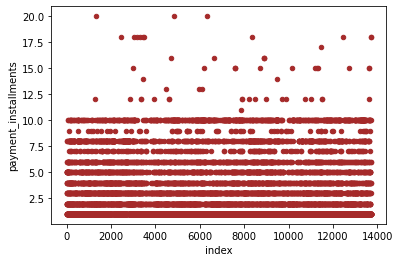

<Figure size 432x288 with 0 Axes>

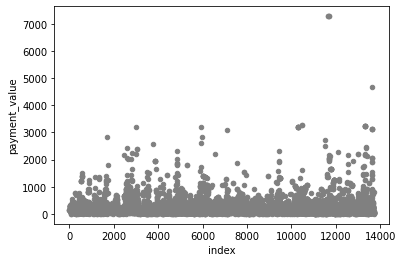

In [16]:
# Checking for outliers
plt.figure()
df.reset_index().plot(kind='scatter', x='index',
                      y='payment_installments', c='brown')
plt.figure()
df.reset_index().plot(kind='scatter', x='index', y='payment_value', c='gray')

In [17]:

# Checking the mean and standar deviation of the payment value (to check how far is the outlier observed in the scatterplot)
mean_pv = df["payment_value"].mean()  # mean of 195.2
std_pv = df["payment_value"].std()  # std of 295.5

Using the value founded from above we now print out the number of outliers that turns out to be 5 , we can easely remove them using drop.

In [18]:
# Seeing how many outliers there are, the output prints 5 payments higher than 4000
# Value of 4000 decided by looking at the scatterplot
outlier1 = df[df['payment_value'] > 4000]
print('\nOutlier dataframe:\n', outlier1)


Outlier dataframe:
                                order_id                       customer_id  \
11673  736e1922ae60d0d6a89247b851902527  ec5b2ba62e574342386871631fafd3fc   
11674  736e1922ae60d0d6a89247b851902527  ec5b2ba62e574342386871631fafd3fc   
11675  736e1922ae60d0d6a89247b851902527  ec5b2ba62e574342386871631fafd3fc   
11676  736e1922ae60d0d6a89247b851902527  ec5b2ba62e574342386871631fafd3fc   
13638  8dbc85d1447242f3b127dda390d56e19  3d979689f636322c62418b6346b1c6d2   

      order_status order_purchase_timestamp   order_approved_at  \
11673    delivered      2018-07-15 14:49:44 2018-07-17 04:31:36   
11674    delivered      2018-07-15 14:49:44 2018-07-17 04:31:36   
11675    delivered      2018-07-15 14:49:44 2018-07-17 04:31:36   
11676    delivered      2018-07-15 14:49:44 2018-07-17 04:31:36   
13638    delivered      2018-06-22 12:23:19 2018-06-22 12:36:36   

      order_delivered_carrier_date order_delivered_customer_date  \
11673          2018-07-20 13:09:00           

In [19]:
# Deleting 5 outliers out of 13718 other orders and resetting the index again
df = df.drop(df[df.payment_value > 4000].index)
df = df.reset_index(drop=True)

To continue whit our visualization we plot the scatterplots of variables that as alredy mentiond are very significant to us , after printing the output we can compere these figures whit the previus one that contained outliers and see the changes !!

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

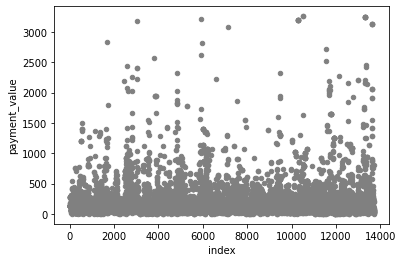

<Figure size 432x288 with 0 Axes>

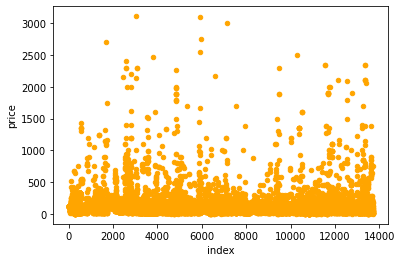

<Figure size 432x288 with 0 Axes>

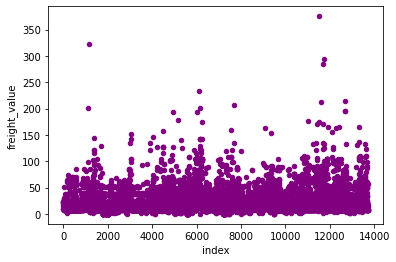

<Figure size 432x288 with 0 Axes>

In [20]:
# Continuing to look at other variables by plotting scatterplots
plt.figure()
df.reset_index().plot(kind='scatter', x='index', y='payment_value',
                      c='gray')  # re-plotting after removing outliers
plt.figure()
df.reset_index().plot(kind='scatter', x='index', y='price', c='orange')
plt.figure()
df.reset_index().plot(kind='scatter', x='index', y='freight_value', c='purple')
plt.figure()

Now we start Looking for Correlations:
Since the dataset is not too large, we can compute the correlation between every pair of attributes using the corr()
method , and helping our self whit a heatmap that facilitates understanding .The correlation coefficient ranges from –1 to 1. When it is close to 1, it means that there is a strong positive correlation while When the coefficient is close to –1, it means
that there is a strong negative correlation . ADD THing we can notice ...?

<Figure size 432x288 with 0 Axes>

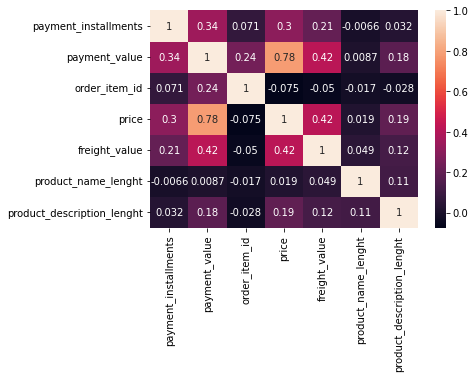

<Figure size 432x288 with 0 Axes>

In [21]:

# Creating a correlation matrix heatmap to look at the relation between variables
sns.heatmap(df.corr(), annot=True)
plt.figure()

Since this is a costumer segmentation task we tought that analisising  where most customers are from was an important insight  .
From the graphs we can esealy state that there are more customers in cities that are capitals (ex São Paulo, Rio de Janeiro, )

Text(0, 0.5, 'Number of Customers')

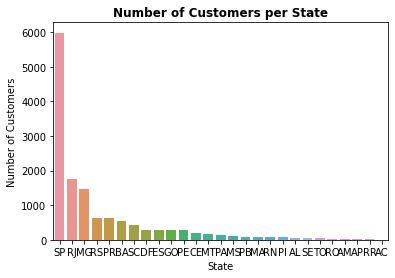

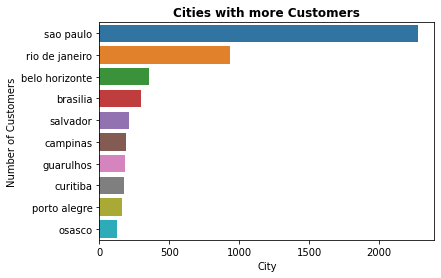

In [22]:
# Counting customers per city and per state and creating dataframes with the purpose of plotting a graph
customerstate = df.groupby('customer_state').count()[
    'customer_id'].reset_index()
customercity = df.groupby('customer_city').count()['customer_id'].reset_index()

# Graph of numer of customers in each state
plt.figure()
sns.barplot(data=customerstate.sort_values('customer_id',
            ascending=False), x='customer_state', y='customer_id')
plt.title('Number of Customers per State', fontweight='bold')
plt.xlabel('State')
plt.ylabel('Number of Customers')

# Graph of top 10 cities with most customers
plt.figure()
sns.barplot(data=customercity.sort_values('customer_id', ascending=False).nlargest(
    10, 'customer_id'), x='customer_id', y='customer_city')
plt.title('Cities with more Customers', fontweight='bold')
plt.xlabel('City')
plt.ylabel('Number of Customers')

To continue our analisis we goup similar categories we founded in the data set this will be useful now for the plots but also later when we proceed whit featurs engeniering .
We decided to arbitrarily assign certain products to different categories following a simple logical criterion(ex for all the products related to fashion and beauty we created a category named fashion_beauty).Than we plotted an insigth that can be very intresting for the Company to have : which are the most orders category of products wich the least ordered ones ?


In [23]:
# Grouping similar categories of product category names in case we use this variable in future analysis (encoding becomes easier, there would be less dummies)
df['product_category_name_english'] = df['product_category_name_english'].replace(['art', 'arts_and_craftmanship', 'sports_leisure',
                                                                                   'garden_tools', 'flowers', 'music', 'musical_instruments',
                                                                                   'books_general_interest', 'books_imported', 'books_technical'], 'hobbies')
df['product_category_name_english'] = df['product_category_name_english'].replace(['air_conditioning', 'bed_bath_table', 'furniture_bedroom',
                                                                                   'furniture_decor', 'furniture_living_room', 'home_appliances',
                                                                                   'home_appliances_2', 'home_comfort_2', 'home_confort',
                                                                                   'home_construction', 'housewares', 'kitchen_dining_laundry_garden_furniture',
                                                                                   'small_appliances', 'small_appliances_home_oven_and_coffee', 'office_furniture',
                                                                                   'signaling_and_security', 'stationery', 'luggage_accessories'], 'home_products')
df['product_category_name_english'] = df['product_category_name_english'].replace(
    ['drinks', 'food', 'food_drink'], 'food_drink')
df['product_category_name_english'] = df['product_category_name_english'].replace(['construction_tools_construction', 'construction_tools_lights',
                                                                                   'construction_tools_safety', 'costruction_tools_garden',
                                                                                   'costruction_tools_tools'], 'construction_tools')
df['product_category_name_english'] = df['product_category_name_english'].replace(['audio', 'auto', 'cds_dvds_musicals', 'cine_photo', 'computers',
                                                                                   'computers_accessories', 'consoles_games', 'dvds_blu_ray', 'electronics',
                                                                                   'fixed_telephony', 'telephony', 'tablets_printing_image'], 'electronic_gadgets')
df['product_category_name_english'] = df['product_category_name_english'].replace(['fashion_bags_accessories', 'fashion_childrens_clothes', 'fashion_male_clothing',
                                                                                   'fashion_shoes', 'fashion_underwear_beach', 'health_beauty', 'perfumery'], 'fashion_beauty')
df['product_category_name_english'] = df['product_category_name_english'].replace(['baby', 'diapers_and_hygiene', 'toys', 'party_supplies', 'pet_shop',
                                                                                   'christmas_supplies', 'cool_stuff', 'watches_gifts'], 'family_festivities')
df['product_category_name_english'] = df['product_category_name_english'].replace(
    ['industry_commerce_and_business', 'market_place'], 'sellers')



Text(0, 0.5, 'Product Category')

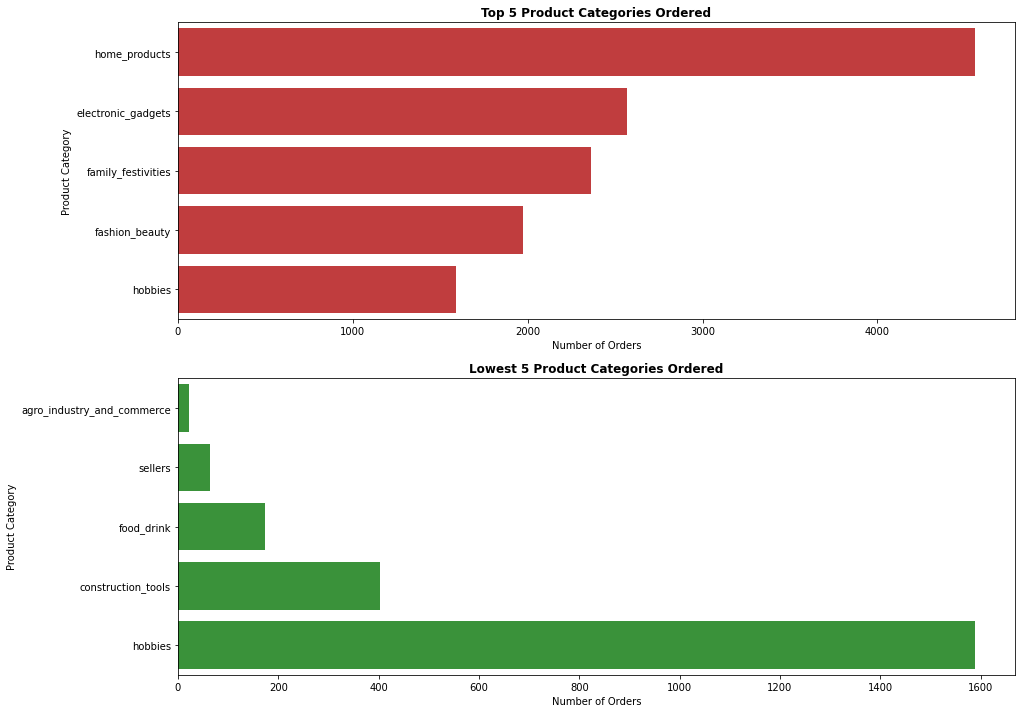

In [25]:
# Counting the product categories to check which one is most and less ordered
best_seller_p = df['product_category_name_english'].value_counts(
).reset_index().nlargest(5, 'product_category_name_english')
worst_seller_p = df['product_category_name_english'].value_counts(
).reset_index().nsmallest(5, 'product_category_name_english')

# Graphs aesthetic
plt.figure(figsize=(15, 12))
green_color = sns.color_palette()[3]
red_color = sns.color_palette()[2]

# Graph of top 10 most ordered products
plt.subplot(211)
sns.barplot(data=best_seller_p, x='product_category_name_english',
            y='index', color=green_color)
plt.title('Top 5 Product Categories Ordered', fontweight='bold')
plt.xlabel('Number of Orders')
plt.ylabel('Product Category')

# Graph of top 10 less ordered products
plt.subplot(212)
sns.barplot(data=worst_seller_p, x='product_category_name_english',
            y='index', color=red_color)
plt.title('Lowest 5 Product Categories Ordered', fontweight='bold')
plt.xlabel('Number of Orders')
plt.ylabel('Product Category')

The last but not least intresting insights we decided to get a look at are order by paiment type and orders whit the number of payment instalments.By looking at the plot on the left we can see that the majority of the costumers is paying whit a credit card these fact can be interpreteted as a canfermation of our firts assumtion because it will not be strange to pay whit a credic card in an ecoomrce .From the plot on the rigth insted we can see that most of our costumers pay their order in one time (non a rate)

Text(0, 0.5, 'Count of Orders')

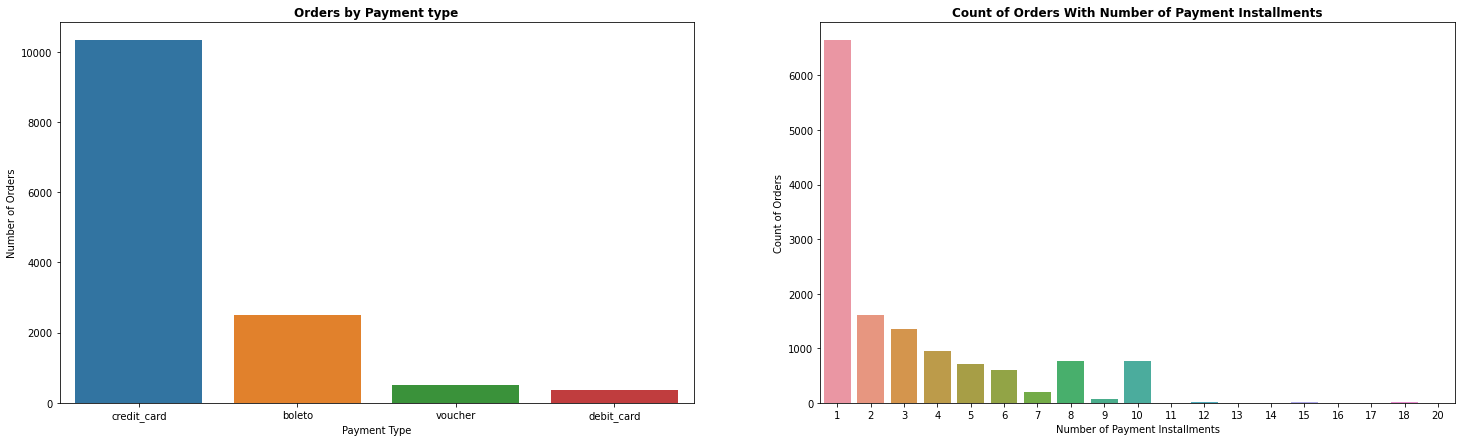

In [26]:

# Counting different payment types to plot which ones are more used
payments_types = df['payment_type'].value_counts().reset_index()

plt.figure(figsize=(25, 7))

# Graph of number of orders per payment type
plt.subplot(121)
sns.barplot(data=payments_types, x='index', y='payment_type')
plt.title('Orders by Payment type', fontweight='bold')
plt.xlabel('Payment Type')
plt.ylabel('Number of Orders')

# Graph of number of orders per number of payment installments
plt.subplot(122)
sns.barplot(data=df['payment_installments'].value_counts(
).reset_index(), x='index', y='payment_installments')
plt.title('Count of Orders With Number of Payment Installments', fontweight='bold')
plt.xlabel('Number of Payment Installments')
plt.ylabel('Count of Orders')

After all these intrasting insigths we procede whit the encoding